In [0]:
!apt-get install -y xvfb python-pygame python-opengl

import os

!pip install pygame

!git clone https://github.com/ntasfi/PyGame-Learning-Environment.git
os.chdir('PyGame-Learning-Environment/')
!pip install -e .

!pip install pyvirtualdisplay gym_ple pygame


from pyvirtualdisplay import Display
display = Display(visible=0, size=(500, 500))
display.start()


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-freefont-ttf libfluidsynth1 libmad0 libmikmod3 libportmidi0
  libsdl-image1.2 libsdl-mixer1.2 libsdl-ttf2.0-0 libsdl1.2debian libsmpeg0
  timgm6mb-soundfont
Suggested packages:
  libgle3 timidity fluid-soundfont-gm fluidsynth musescore
The following NEW packages will be installed:
  fonts-freefont-ttf libfluidsynth1 libmad0 libmikmod3 libportmidi0
  libsdl-image1.2 libsdl-mixer1.2 libsdl-ttf2.0-0 libsdl1.2debian libsmpeg0
  python-opengl python-pygame timgm6mb-soundfont xvfb
0 upgraded, 14 newly installed, 0 to remove and 6 not upgraded.
Need to get 13.3 MB of archives.
After this operation, 33.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 fonts

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '500x500x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '500x500x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
from google.colab import drive
drive.mount('/data/')
from pathlib import Path

base_dir=Path('/data/My Drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /data/


In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import gym_ple

import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,9]
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# ENV='CartPole-v0'
# ENV='SpaceInvadersNoFrameskip-v4'
# ENV='PongNoFrameskip-v4'
ENV='FlappyBird-v0'

torch.manual_seed(0)
np.random.seed(0)

env = gym.make(ENV)
env.seed(0)
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pygame 1.9.5
Hello from the pygame community. https://www.pygame.org/contribute.html
couldn't import doomish
Couldn't import doom


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Environment '<class 'gym_ple.ple_env.PLEEnv'>' has deprecated methods '_step' and '_reset' rather than 'step' and 'reset'. Compatibility code invoked. Set _gym_disable_underscore_compat = True to disable this behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [0]:
from collections import deque

Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state', 'done'))

    
class PriorityReplayMemory:
    # modified from https://github.com/susantamoh84/Deep-Reinforcement-Learning-Hands-On/blob/master/Chapter07/bench/prio_buffer_bench.py
    def __init__(self, capacity, alpha=0.6, beta_start=0.4, beta_frames=100000):
        self.alpha = alpha
        self.buffer = deque(maxlen=capacity)
        self.priorities = deque(maxlen=capacity)
        
        self.beta_start = beta_start
        self.beta_frames = beta_frames
        self.frame = 1
        
    def beta_by_frame(self, frame_idx):
        return min(1.0, self.beta_start + frame_idx * (1.0 - self.beta_start) / self.beta_frames)

    def __len__(self):
        return len(self.buffer)

    def push(self, sample):
        max_prio = max(self.priorities) if self.priorities else 1.0
        self.buffer.append(sample)
        self.priorities.append(max_prio)

    def sample(self, batch_size):
        probs = np.array(self.priorities, dtype=np.float32) ** self.alpha
        probs /= probs.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs, replace=True)
        samples = [self.buffer[idx] for idx in indices]
        total = len(self.buffer)
        
        beta = self.beta_by_frame(self.frame)
        self.frame += 1
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        return samples, indices, torch.Tensor(weights).to(device)
    

    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(batch_indices, batch_priorities):
            self.priorities[idx] = prio

class ReplayMemory:

    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, sample):
        """Saves a transition."""
        self.buffer.append(sample)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=True)
        samples = [self.buffer[idx] for idx in indices]
        return samples, None, torch.Tensor([1/len(self.buffer) for _ in range(batch_size)]).to(device)
    
    def update_priorities(self, batch_indices, batch_priorities):
        pass
    
    def __len__(self):
        return len(self.buffer)

In [0]:
class DQN(nn.Module):

    def __init__(self, h, w):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, 2) # 448 or 512

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))
    
    
class DDQN(nn.Module):
    # 3 frames

    def __init__(self, h, w):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.val = nn.Linear(linear_input_size, 1)
        self.adv = nn.Linear(linear_input_size, 2)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        
        x=x.view(x.size(0), -1)
        val=self.val(x)
        adv=self.adv(x)
        
        x=val+adv-adv.mean(1,keepdim=True)
        return x
    
    
    
class DDQN2(nn.Module):
    # 3 frames, change convs, add fc

    def __init__(self, h, w):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(64)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2, padding=0):
            return (size - kernel_size +2*padding ) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w,8,4),4,2),3,1)
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h,8,4),4,2),3,1)
        linear_input_size = convw * convh * 64
        fc_output_size=32
        
        self.fc=nn.Linear(linear_input_size, fc_output_size)
        self.val = nn.Linear(fc_output_size, 1)
        self.adv = nn.Linear(fc_output_size, 2)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        
        x = F.relu(self.fc(x.view(x.size(0), -1)))
        val=self.val(x)
        adv=self.adv(x)
        
        x=val+adv-adv.mean(1,keepdim=True)
        return x
       

class DDQN3(nn.Module):
    # 3 frames, no bn, add 2 fc, add dropout

    def __init__(self, h, w):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 8, stride = 4, padding=0):
            return (size - kernel_size +2*padding ) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w,8,4),4,2),3,1)
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h,8,4),4,2),3,1)
        linear_input_size = convw * convh * 64
        fc_output_size=512
        self.dropout=nn.Dropout()
        self.fc_val=nn.Linear(linear_input_size, fc_output_size)
        self.fc_adv=nn.Linear(linear_input_size, fc_output_size)
        self.val = nn.Linear(fc_output_size, 1)
        self.adv = nn.Linear(fc_output_size, N_ACTION)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.dropout(x)
        
        x_val = F.relu(self.fc_val(x.view(x.size(0), -1)))
        x_adv = F.relu(self.fc_adv(x.view(x.size(0), -1)))
        val=self.val(x_val)
        adv=self.adv(x_adv)
        
        x=val+adv-adv.mean(1,keepdim=True)
        return x
       
class DDQN4(nn.Module):
    # 4 frames,

    def __init__(self, h, w):
        super().__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(64)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 6, stride = 2, padding=0):
            return (size - kernel_size +2*padding ) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w,8,4),4,2),3,1)
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h,8,4),4,2),3,1)

        linear_input_size = convw * convh * 64
        fc_output_size=512
        self.fc_val=nn.Linear(linear_input_size, fc_output_size)
        self.fc_adv=nn.Linear(linear_input_size, fc_output_size)
        self.val = nn.Linear(fc_output_size, 1)
        self.adv = nn.Linear(fc_output_size, N_ACTION)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.float()
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        
        x_val = F.relu(self.fc_val(x.view(x.size(0), -1)))
        x_adv = F.relu(self.fc_adv(x.view(x.size(0), -1)))
        val=self.val(x_val)
        adv=self.adv(x_adv)
        
        
        x=val+adv-adv.mean(1,keepdim=True)
        return x
    

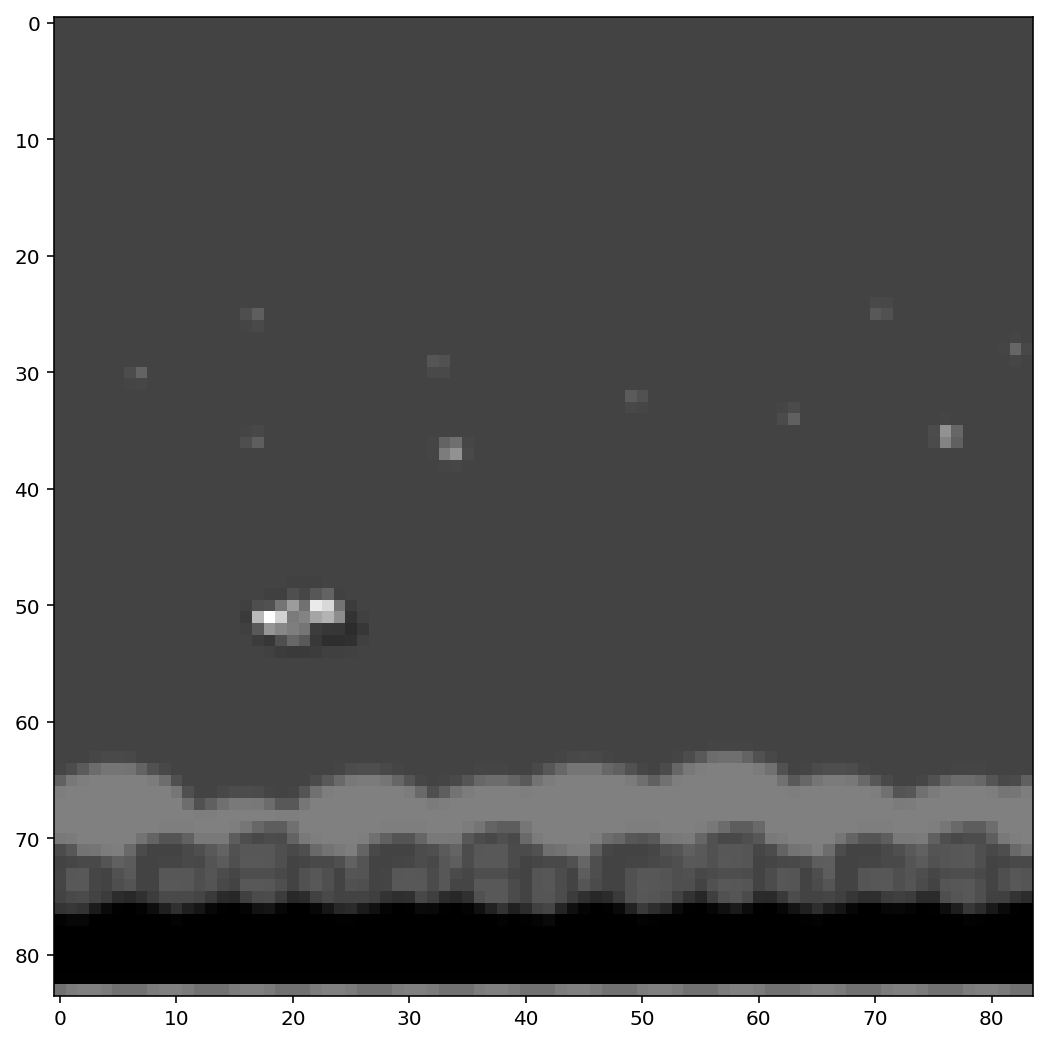

In [0]:
process_pic = T.Compose([
                    T.ToPILImage(),
#                     T.Grayscale(),
                    T.Resize((84,84)),
                    T.ToTensor(),
                        ])



def get_screen_flappy():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    _, screen_height, screen_width = screen.shape
    screen = screen[:, :int(screen_height * 0.8)]
    screen = screen.mean(0).astype('uint8')
#     (values,counts) = np.unique(screen,return_counts=True)
#     ind=np.argmax(counts)
#     bg_color=values[ind]
#     print(bg_color)
#     bg_color=[157,94]
    
#     screen[screen==157] = 0
#     screen[screen==94] = 0

    screen = torch.from_numpy(screen)
    
    screen = process_pic(screen.unsqueeze(0))
    screen = (screen*255).type(torch.uint8)

    return screen.unsqueeze(0).to(device)


def get_screen_cartpole():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    
    screen = screen.mean(0).astype('uint8')
    screen = torch.from_numpy(screen)
    screen = process_pic(screen.unsqueeze(0))
    screen = (screen*255).type(torch.uint8)
    
    return screen.unsqueeze(0).to(device)
    


def get_screen_space():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.2):int(screen_height)]
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    screen = process_pic(screen)
    

    return screen.unsqueeze(0).to(device)

get_screen=get_screen_flappy
# get_screen=get_screen_cartpole

env.reset()

for _ in range(3):
    plt.clf()
    display.clear_output(wait=True)
    plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).squeeze(2).numpy(),cmap='gray')
    plt.pause(0.0001)
    action = env.action_space.sample()
    env.step(action)


In [0]:
BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 1
EPS_END = 0.001
FRAME_SKIP = 2
EPS_DECAY = 300000
TARGET_UPDATE = 1000
PLOT_INTERVAL = 50
REPLAY_SIZE= 100000
SAVE_CHECKPOINT=500
FULL_RANDOM=30000
LR = 1e-5
USE_PRIORITY_REPLAY = False
N_ACTION = env.action_space.n
USE_BONUS_REWARD = False


init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

policy_net = DDQN4(screen_height, screen_width).to(device)
target_net = DDQN4(screen_height, screen_width).to(device)
print(policy_net)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(),lr=LR)
# optimizer = optim.RMSprop(policy_net.parameters(),lr=LR)
if USE_PRIORITY_REPLAY:
    memory = PriorityReplayMemory(REPLAY_SIZE)
else:
    memory = ReplayMemory(REPLAY_SIZE)



def select_action(state):
    global action_q
    policy_net.eval()
    sample = random.random()
    eps_threshold = max( EPS_START - (EPS_START - EPS_END)/EPS_DECAY *steps_done,EPS_END)
    if not is_full_random() and sample > eps_threshold:
        with torch.no_grad():
            t=policy_net(state)
            action_q=t.max().item()
            return t.max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(N_ACTION)]], device=device, dtype=torch.long)



import time
def plot_durations():
    if i_episode%PLOT_INTERVAL==0:
        global action_qs
        plt.clf()
        display.clear_output(wait=True)
        rewards_t = torch.tensor(total_rewards, dtype=torch.float)
        bonus_rewards_t = torch.tensor(total_bonus_rewards, dtype=torch.float)
        action_qs_t = torch.tensor(action_qs, dtype=torch.float)
        plt.title('Training...episode:{},steps:{},time used:{}s'.format(i_episode,steps_done,round(time_used)))
        plt.xlabel('Episode')
        plt.ylabel('Duration')
#         plt.plot(action_qs_t.numpy(),label='Q')
        if USE_BONUS_REWARD:
            plt.plot(bonus_rewards_t.numpy(),label='bonus_reward')
        plt.plot(rewards_t.numpy(),label='reward')
        # Take 100 episode averages and plot them too
        if len(rewards_t) >= 100:
            means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(99), means))
            plt.plot(means.numpy(),label='reward_mean')
        if len(action_qs_t) >= 100:
            means = action_qs_t.unfold(0, 100, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(99), means))
            plt.plot(means.numpy(),label='Q_mean')
        plt.legend()
        plt.savefig(base_dir/'dqn'/'plot2.png')
        plt.pause(0.00001)  # pause a bit so that plots are updated
        plt.close()
        


DDQN4(
  (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_val): Linear(in_features=3136, out_features=512, bias=True)
  (fc_adv): Linear(in_features=3136, out_features=512, bias=True)
  (val): Linear(in_features=512, out_features=1, bias=True)
  (adv): Linear(in_features=512, out_features=2, bias=True)
)


In [0]:
def optimize_model():
    policy_net.train()
    if len(memory) < BATCH_SIZE:
        return
    if is_full_random():
        return
        
    samples, ids, weights = memory.sample(BATCH_SIZE)
    
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*samples))
    

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    with torch.no_grad():
        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    diff = state_action_values.squeeze() - expected_state_action_values.squeeze()
    loss=torch.zeros(diff.shape)
    for index,(i,j) in enumerate(zip(diff,weights)):
        if -1<i<1:
            loss[index]=(i * i)/2 * j
        else:
            loss[index]=(i.abs()-1/2)*j
    loss=loss.mean().to(device)
    
#     loss = F.mse_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    delta = diff.abs().detach().cpu().numpy().tolist()
    memory.update_priorities(ids, delta)


    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
#     torch.nn.utils.clip_grad_norm_(policy_net.parameters(),1)
    optimizer.step()
    
    

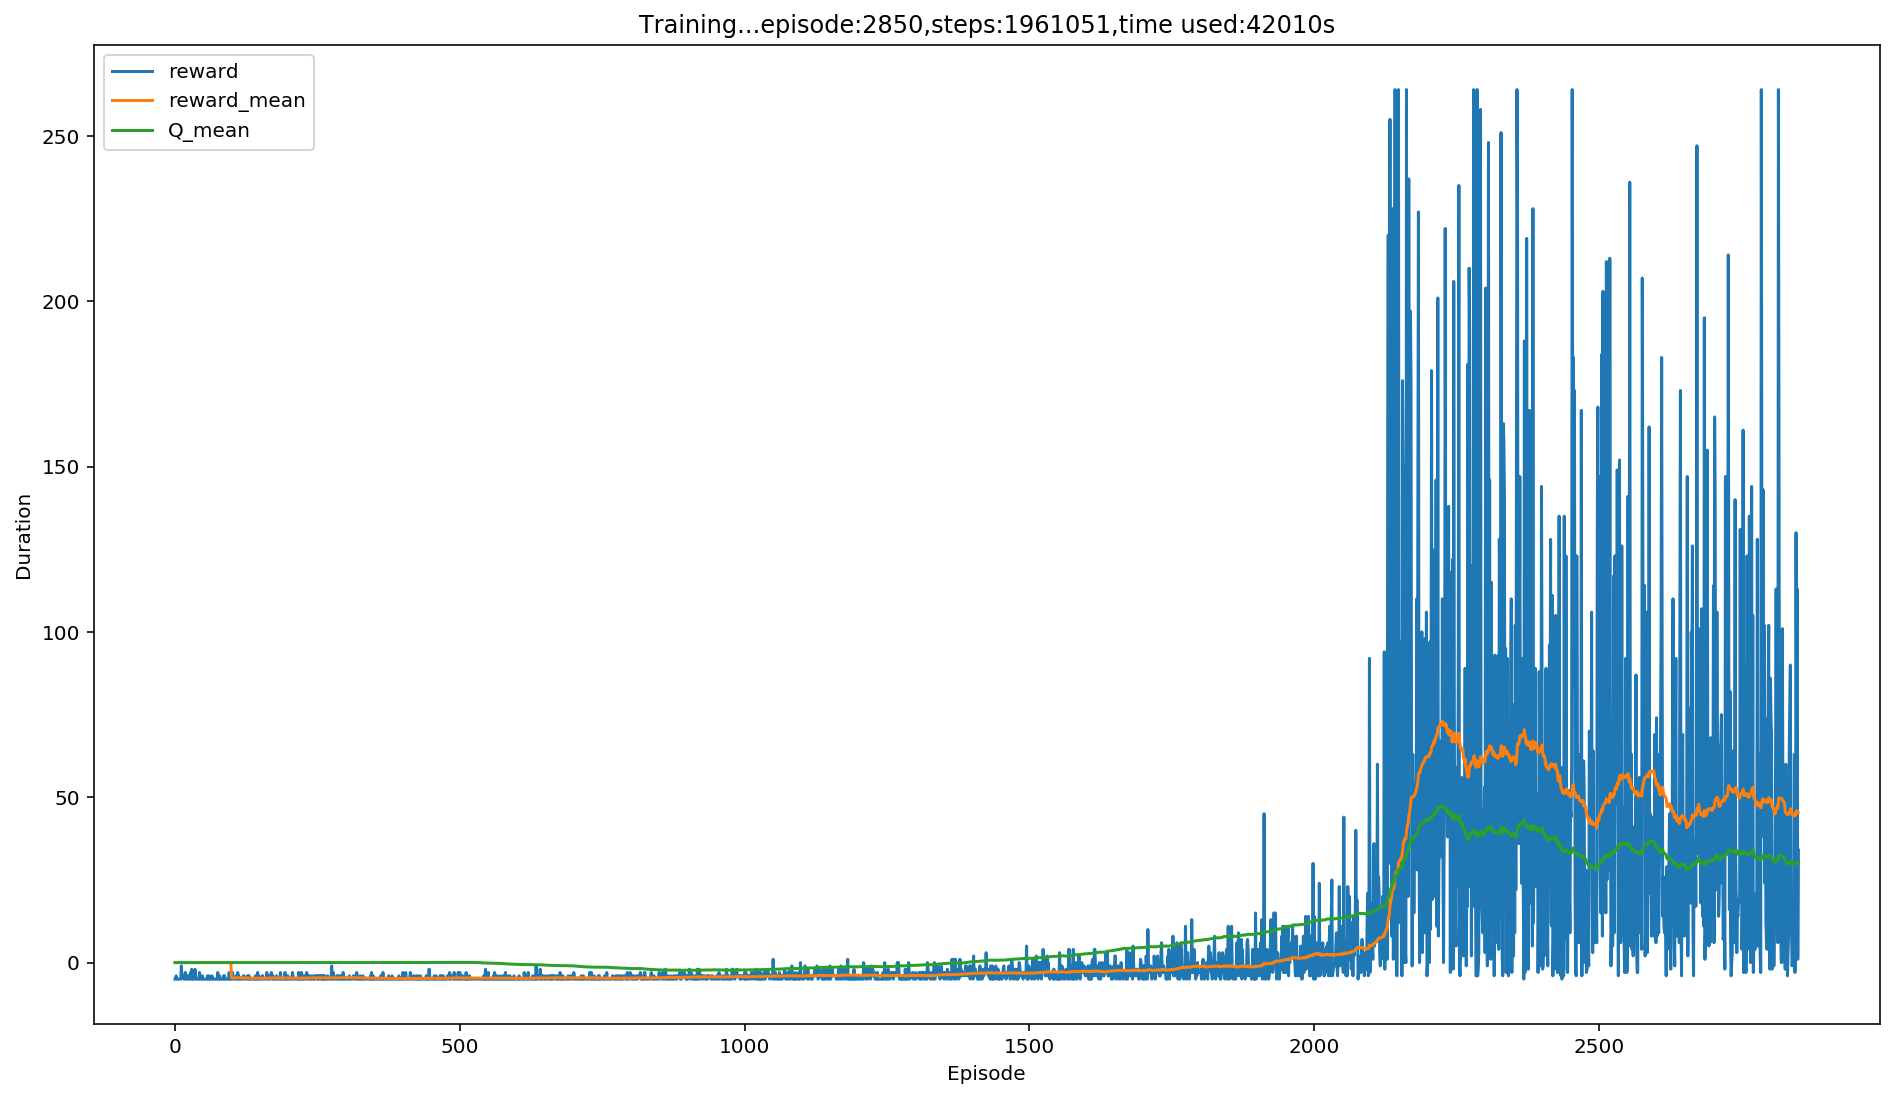

In [0]:
from collections import deque
import time
import os

from pathlib import Path



checkpoint_file=base_dir/'dqn'/'flappy_checkpoint.pt'
temp_policy=base_dir/'dqn'/'flappy_policy.pt'



def save_checkpoint():
    torch.save({
                'i_episode': i_episode+1,
                'total_rewards':total_rewards,
                'total_bonus_rewards':total_bonus_rewards,
                'steps_done':steps_done,
                'policy_state_dict': policy_net.state_dict(),
                'target_state_dict': target_net.state_dict(),
                'optimizer' : optimizer.state_dict(),
                'time_used' : time_used,
            },checkpoint_file)

def load_checkpoint():
    global i_episode,policy_net,optimizer,steps_done,memory,total_rewards,time_used,total_bonus_rewards
    if os.path.exists(checkpoint_file):
        checkpoint=torch.load(checkpoint_file)
        i_episode=checkpoint['i_episode']
        total_rewards=checkpoint['total_rewards']
        total_bonus_rewards=checkpoint['total_bonus_rewards']
        steps_done=checkpoint['steps_done']
        time_used=checkpoint['time_used']
        optimizer.load_state_dict(checkpoint['optimizer'])
        policy_net.load_state_dict(checkpoint['policy_state_dict'])
        target_net.load_state_dict(checkpoint['target_state_dict'])
        


resume=False

i_episode = 0
total_rewards = []
total_bonus_rewards = []
action_qs = []
steps_done = 0
time_used = 0

if resume:
    load_checkpoint()
    
    
def is_key_frame(t):
    return t%FRAME_SKIP==0

def is_full_random():
    return steps_done<FULL_RANDOM

for i_episode in count(i_episode):
    # Initialize the environment and state
    start_time=time.time()
    env.reset()
    total_reward=0
    total_bonus_reward=0
    last_screen = get_screen()
    current_screen = get_screen()
    screens = deque([current_screen] * 4, 4)
    state = torch.cat(list(screens), dim=1)
    last_action=None
    key_frame_reward=0.0
    action_q=None
    episode_q=[]
    
    for t in count():
        # Select and perform an action
        steps_done += 1
        if is_key_frame(t):
            action = select_action(state)
            last_action=action
            if action_q is not None:
                episode_q.append(action_q+total_reward)
        else:
            action=last_action
        _, reward, done, _ = env.step(action.item())
        total_reward+=reward
        key_frame_reward+=reward
        total_bonus_reward+=reward+0.05
        
        
        
        # Observe new state
        last_screen = current_screen
        
        if is_key_frame(t) or done:
            current_screen = get_screen()
            screens.append(current_screen)
        if not done:
            next_state = torch.cat(list(screens), dim=1)
        else:
            next_state = None


        # Store the transition in memory
        if is_key_frame(t) or done:
            if USE_BONUS_REWARD:
                bonus_reward_t = torch.tensor([reward+0.05], device=device)
                memory.push(Transition(state, action, bonus_reward_t, next_state, done))
                
            else:
                key_frame_reward_t=torch.tensor([key_frame_reward], device=device)
                memory.push(Transition(state, action, key_frame_reward_t, next_state, done))
                key_frame_reward=0

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        
        if done:
            total_rewards.append(total_reward)
            total_bonus_rewards.append(total_bonus_reward)
            if episode_q:
                action_qs.append(sum(episode_q)/len(episode_q))
            else:
                action_qs.append(0)
            plot_durations()
            break
            
        if steps_done % TARGET_UPDATE==0 and not is_full_random():
            target_net.load_state_dict(policy_net.state_dict())
        
#         if steps_done%100==0:
#             print(np.array(list(memory.priorities)).max(),np.array(list(memory.priorities)).mean(),len(memory.buffer))
    if i_episode and i_episode%SAVE_CHECKPOINT==0 and not is_full_random():
        save_checkpoint()
        torch.save(policy_net,temp_policy)
        
        
    time_used+=time.time()-start_time



print('Complete')
env.render()
env.close()
# plt.ioff()
# plt.show()

print(sum(total_rewardsepisode_durations[-100:])/100)


In [0]:
import gym
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import PIL
from IPython import display



env = gym.make(ENV)
env.reset()

for _ in range(2000):
    plt.clf()
    display.clear_output(wait=True)
    plt.imshow(env.render(mode='rgb_array')) # only call this once
    plt.pause(0.0001)
    action = env.action_space.sample()
    env.step(action)
    


In [0]:
import gym
import matplotlib.pyplot as plt
import PIL
from IPython import display
import torch

# env = gym.make(ENV)
# for i_episode in range(1):
#     observation = env.reset()
#     for t in range(100):

#         plt.clf()
#         plt.imshow(env.render(mode='rgb_array'))
#         plt.axis('off')
#         display.clear_output(wait=True)
#         display.display(plt.gcf())
#         print(observation)
#         action = env.action_space.sample()
#         observation, reward, done, info = env.step(action)
#         if done:
#             print("Episode finished after {} timesteps".format(t+1))
#             break
# display.clear_output(wait=True)


env = gym.make(ENV)
env.reset()
model=torch.load(base_dir/'policy.pt')
model.eval()
last_screen = get_screen()
current_screen = get_screen()

img = plt.imshow(current_screen.to('cpu').squeeze(0).permute(1, 2, 0))
state = current_screen


def select_action_by_model(state):
    with torch.no_grad():
        # t.max(1) will return largest column value of each row.
        # second column on max result is index of where max element was
        # found, so we pick action with the larger expected reward.
        return policy_net(state).max(1)[1].view(1, 1)


for t in count():
    
    # Select and perform an action
    action = select_action_by_model(state)
    _, reward, done, _ = env.step(action.item())

    reward = torch.tensor([reward], device=device)

    # Observe new state
    last_screen = current_screen
    current_screen = get_screen()

    plt.imshow(current_screen.to('cpu').squeeze(0).permute(1, 2, 0))
    
    if not done:
        next_state = current_screen
    else:
        next_state = None

    # Store the transition in memory
    memory.push(state, action, next_state, reward)
    state = next_state
    display.clear_output(wait=True)
    plt.pause(0.1)
    print(t,action[0])
    if next_state is None:
        break
    
# img = plt.imshow(env.render(mode='rgb_array')) # only call this once
# for _ in range(100):
#     img.set_data(env.render(mode='rgb_array')) # just update the data
#     display.display(plt.gcf())
#     display.clear_output(wait=True)
#     action = env.action_space.sample()
#     env.step(action)

Here is the diagram that illustrates the overall resulting data flow.

.. figure:: /_static/img/reinforcement_learning_diagram.jpg

Actions are chosen either randomly or based on a policy, getting the next
step sample from the gym environment. We record the results in the
replay memory and also run optimization step on every iteration.
Optimization picks a random batch from the replay memory to do training of the
new policy. "Older" target_net is also used in optimization to compute the
expected Q values; it is updated occasionally to keep it current.


